In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
from sklearn.cluster import KMeans
import random
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
from cv2 import filter2D
import skimage.feature

import useful as us


In [4]:
def get_gauss_feat_im(im, sigma=1, normalize=True):
    """Gauss derivative feaures for every image pixel.
    Arguments:
        image: a 2D image, shape (r, c).
        sigma: standard deviation for Gaussian derivatives.
        normalize: flag indicating normalization of features.
    Returns:
        imfeat: 3D array of size (r, c, 15) with a 15-dimentional feature
             vector for every pixel in the image.
    Author: vand@dtu.dk, 2020
    """
      
    r, c = im.shape
    imfeat = np.zeros((r, c, 15))
    imfeat[:, :, 0] = scipy.ndimage.gaussian_filter(im, sigma, order=0)
    imfeat[:, :, 1] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 1])
    imfeat[:, :, 2] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 0])
    imfeat[:, :, 3] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 2])
    imfeat[:, :, 4] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 1])
    imfeat[:, :, 5] = scipy.ndimage.gaussian_filter(im, sigma, order=[2, 0])
    imfeat[:, :, 6] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 3])
    imfeat[:, :, 7] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 2])
    imfeat[:, :, 8] = scipy.ndimage.gaussian_filter(im, sigma, order=[2, 1])
    imfeat[:, :, 9] = scipy.ndimage.gaussian_filter(im, sigma, order=[3, 0])
    imfeat[:, :, 10] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 4])
    imfeat[:, :, 11] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 3])
    imfeat[:, :, 12] = scipy.ndimage.gaussian_filter(im, sigma, order=[2, 2])
    imfeat[:, :, 13] = scipy.ndimage.gaussian_filter(im, sigma, order=[3, 1])
    imfeat[:, :, 14] = scipy.ndimage.gaussian_filter(im, sigma, order=[4, 0])

    if normalize:
        imfeat -= np.mean(imfeat, axis=(0, 1))
        im_std = np.std(imfeat, axis=(0, 1))
        im_std[im_std<10e-10] = 1
        imfeat /= im_std
    
    return imfeat

def get_gauss_feat_multi(im, sigma = [1, 2, 4], normalize = True):
    '''Multi-scale Gauss derivative feaures for every image pixel.
    Arguments:
        image: a 2D image, shape (r, c).
        sigma: list of standard deviations for Gaussian derivatives.
        normalize: flag indicating normalization of features.
    Returns:
        imfeat: a a 3D array of size (r*c, n_scale, 15) with n_scale features in each pixels, and
             n_scale is length of sigma. Each pixel contains a feature vector and feature
             image is size (r, c, 15*n_scale).
    Author: abda@dtu.dk, 2021

    '''
    imfeats = []
    for i in range(0, len(sigma)):
        feat = get_gauss_feat_im(im, sigma[i], normalize)
        imfeats.append(feat.reshape(-1, feat.shape[2]))
    
    imfeats = np.asarray(imfeats).transpose(1, 0, 2)
    return imfeats

In [6]:
# Data directory
data_dir = 'data_week4/'

# Training of the data

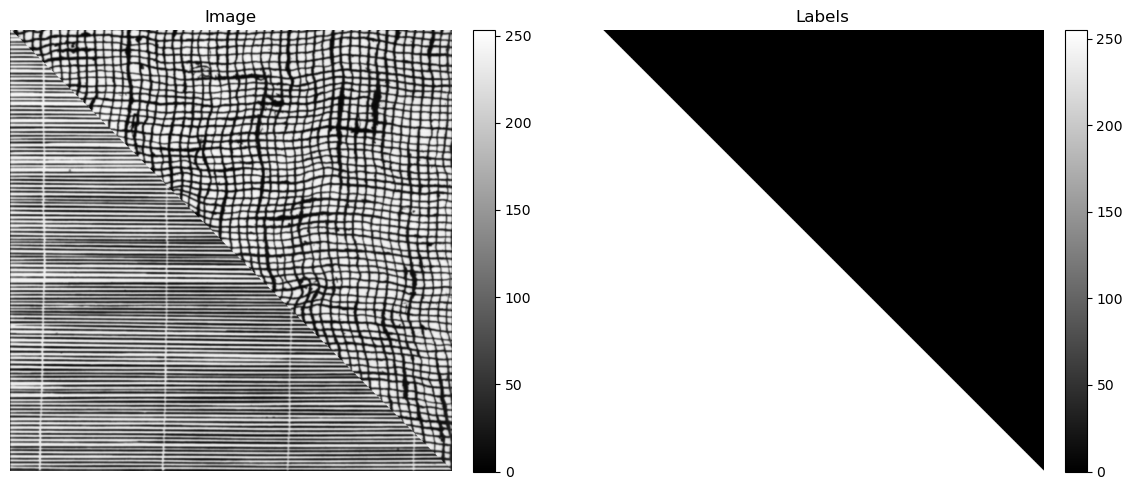

In [11]:
# Load images
im = cv2.imread(data_dir + '2labels/training.png', 0)
im_labels = cv2.imread(data_dir + '2labels/training_labels.png', 0)

# Visualize images
us.display_images([im, im_labels], ['Image', 'Labels'])

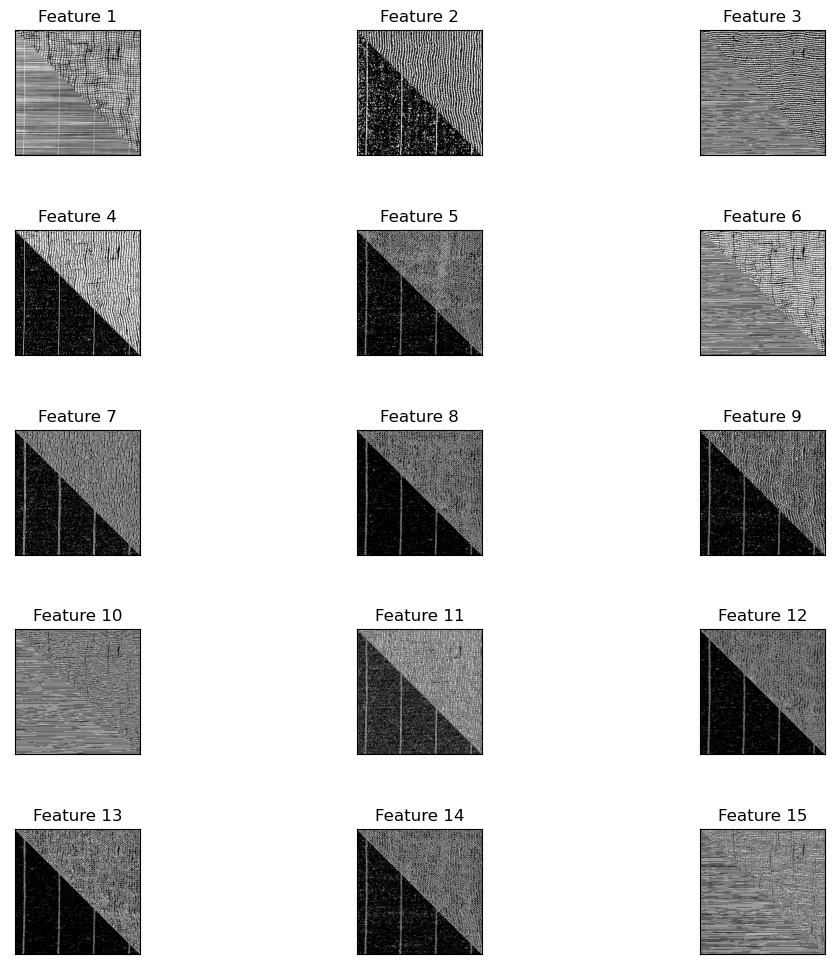

In [13]:
# Define the scales for Gaussian derivatives
sigma = [1, 2, 4]

# Compute the multi-scale Gaussian features for the training image
imfeats = get_gauss_feat_multi(im, sigma, True)

# Reshape the features to match the original image dimensions
imfeats_reshaped = imfeats.reshape(im.shape[0], im.shape[1], -1)

# Display some of the computed features
plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(min(imfeats_reshaped.shape[2], 15)):
    plt.subplot(5, 3, i+1)
    plt.imshow(imfeats_reshaped[:, :, i], cmap='gray')
    plt.title('Feature ' + str(i+1))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [14]:
# Flatten the feature image for further processing
imfeats_flattened = imfeats_reshaped.reshape(-1, imfeats_reshaped.shape[-1])
print(imfeats_flattened.shape)  # Output the shape for verification

(409600, 45)


In [15]:
# Identify unique labels in the training labels image
unique_labels = np.unique(im_labels)
nl = len(unique_labels)  # Number of unique labels

# Initialize the label probability image
r, c = im_labels.shape
L = np.zeros((r, c, nl))
for i, label in enumerate(unique_labels):
    L[:, :, i] = (im_labels == label).astype(int)

# Flatten the label probability image for further processing
im_labels_prob = L
print(im_labels_prob.shape)  # Output the shape for verification


(640, 640, 2)


In [17]:
# Flatten the label probability image for further processing
labels_flattened = im_labels_prob.reshape(-1, nl)
print(labels_flattened.shape)  # Output the shape for verification

(409600, 2)


In [18]:
# Select a random subset of feature vectors and corresponding labels
num_samples = 5000
indices = random.sample(range(imfeats_flattened.shape[0]), num_samples)

# Extract the random sample of features and labels
sample_feats = imfeats_flattened[indices]
sample_labels = labels_flattened[indices]
print("Shape of sample_feats: ", sample_feats.shape)  # Output the shape for verification
print("Shape of sample_labels: ", sample_labels.shape)  # Output the shape for verification

Shape of sample_feats:  (5000, 45)
Shape of sample_labels:  (5000, 2)


In [19]:
# Perform K-means clustering on the sample features
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(sample_feats)
cluster_centers = kmeans.cluster_centers_
print("Shape of cluster_centers: ", cluster_centers.shape)  # Output the shape for verification

c:\Users\Alejandro\anaconda3\envs\course02502\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of cluster_centers:  (100, 45)


In [21]:
# Initialize the label probabilities for each cluster
label_probs = np.zeros((num_clusters, im_labels_prob.shape[-1]))

# Assign label probabilities based on the clusters
labels_pred = kmeans.predict(sample_feats)
for i in range(num_clusters):
    cluster_indices = np.where(labels_pred == i)[0]
    if len(cluster_indices) > 0:
        cluster_labels = sample_labels[cluster_indices]
        label_probs[i] = np.mean(cluster_labels, axis=0)

# Output a few label probabilities for verification
print(label_probs[:5])
print("Shape of label_probs: ", label_probs.shape)

[[1.         0.        ]
 [0.         1.        ]
 [0.81818182 0.18181818]
 [0.96551724 0.03448276]
 [0.86956522 0.13043478]]
Shape of label_probs:  (100, 2)


# Apply to an image

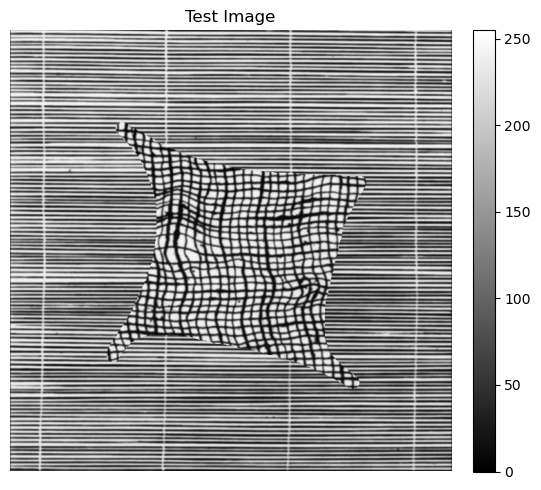

In [22]:
# Load the test image
im = cv2.imread(data_dir + '2labels/test_easy.png', 0)

# Display the test image
us.display_images([im], ['Test Image'])

In [23]:
# Compute the multi-scale Gaussian features for the test image
test_imfeats = get_gauss_feat_multi(im, sigma, True)

# Reshape the features to match the original image dimensions
test_imfeats_reshaped = test_imfeats.reshape(im.shape[0], im.shape[1], -1)
print("Shape of test_imfeats_reshaped: ", test_imfeats_reshaped.shape)

# Flatten the feature image for clustering
test_imfeats_flattened = test_imfeats_reshaped.reshape(-1, test_imfeats_reshaped.shape[-1])
print("Shape of test_imfeats_flattened: ", test_imfeats_flattened.shape)

Shape of test_imfeats_reshaped:  (640, 640, 45)
Shape of test_imfeats_flattened:  (409600, 45)


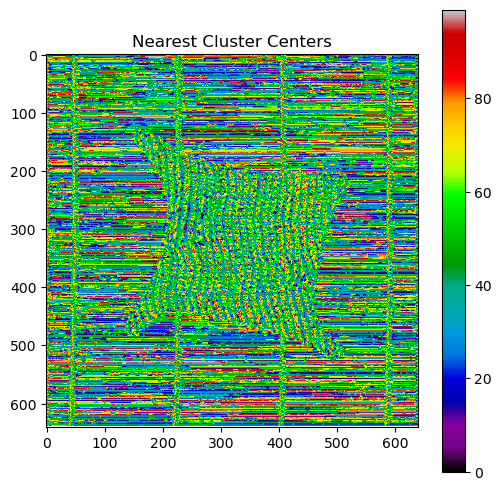

In [24]:
# Find the nearest cluster for each feature in the test image
nearest_clusters = kmeans.predict(test_imfeats_flattened)

# Reshape the nearest clusters array to match the test image dimensions
nearest_cluster_image = nearest_clusters.reshape(im.shape)

# Display the nearest cluster centers
plt.figure(figsize=(6, 6))
plt.imshow(nearest_cluster_image, cmap='nipy_spectral')
plt.title('Nearest Cluster Centers')
plt.colorbar()
plt.show()

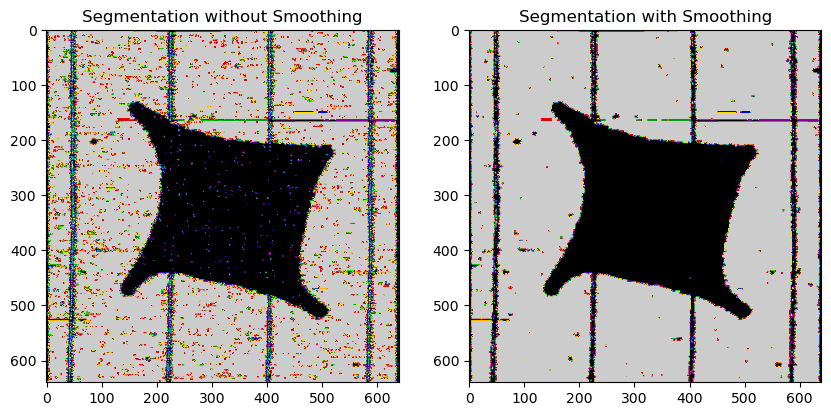

In [25]:
# Initialize the probability image for the test image
r, c = im.shape
nl = label_probs.shape[1]
probability_image = np.zeros((r, c, nl))

# Fill in the probability image based on the nearest clusters
for i in range(r):
    for j in range(c):
        cluster_index = nearest_cluster_image[i, j]
        probability_image[i, j, :] = label_probs[cluster_index]

# Compute the segmentation by taking the maximum probability label for each pixel
segmentation = np.argmax(probability_image, axis=2)

# Optional: Smooth the probability image before selecting the most probable label
smoothed_probability_image = np.zeros_like(probability_image)
for i in range(nl):
    smoothed_probability_image[:, :, i] = gaussian_filter(probability_image[:, :, i], sigma=1)

# Recompute the segmentation based on the smoothed probability image
smoothed_segmentation = np.argmax(smoothed_probability_image, axis=2)

# Display the segmentation results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(segmentation, cmap='nipy_spectral')
plt.title('Segmentation without Smoothing')
plt.subplot(1, 2, 2)
plt.imshow(smoothed_segmentation, cmap='nipy_spectral')
plt.title('Segmentation with Smoothing')
plt.show()


# With a given dictionary

In [27]:
# Data directory
data_dir = 'data_2023/'

[[0.5337 0.0036 0.4627]
 [0.3278 0.0111 0.6611]
 [0.8107 0.     0.1893]]
(256, 3)


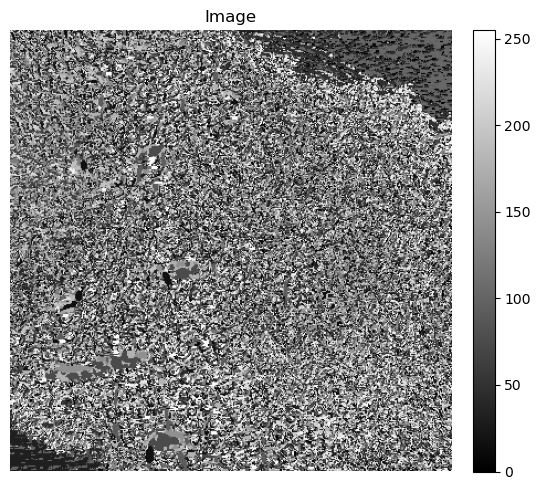

In [33]:
# Load the data
im = skimage.io.imread(f'{data_dir}liver_assignment.png') 

# Open the disctionary and display the data
label_probs = np.loadtxt(data_dir + 'dictionary_probabilities.txt')

# Print 3 rows of the dictionary
print(label_probs[:3])
print(label_probs.shape)

# Visualize images
us.display_images([im], ['Image'])

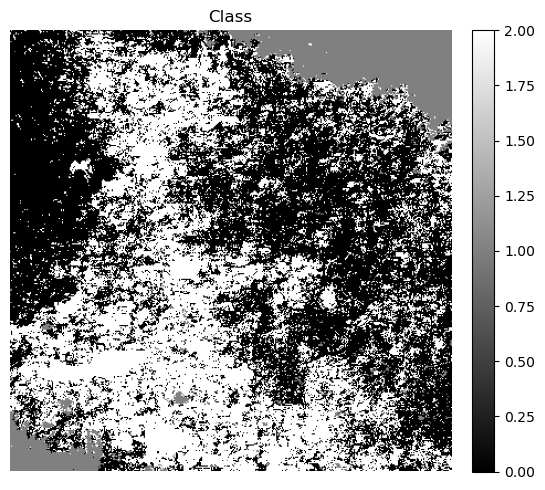

Class 0: 50.18%
Class 1: 8.85%
Class 2: 40.97%


In [35]:
# Build the probability image
prob_im = label_probs[im]

# For each pixel, select the class with the highest probability
class_im = np.argmax(prob_im, axis=2)

# Display the result
us.display_images([class_im], ['Class'])

# Print the result percentage of each class
for i in range(3):
    print(f'Class {i}: {100*(class_im == i).mean():.2f}%')

# Probability of being in each class

In [36]:
image1 = np.array([4, 350, 1])
image2 = np.array([45, 147, 36])

image = image1 + image2
prob = image/image.sum() # Probability of each class
print('Probability of each class:', prob)

Probability of each class: [0.08404803 0.85248714 0.06346484]


# Dictionary clustering given distances and labels

In [40]:
# Data directory
data_dir = 'data_2021/'

In [46]:
# Open the data
distances = np.loadtxt(data_dir + 'distances.txt')
labels = np.loadtxt(data_dir + 'labels.txt')

print("Sample of distances:\n", distances[:3])
print("Sample of labels:\n", labels[:3])

Sample of distances:
 [[ 4.4  5.9  4.9  0.4  3.3  4.4  2.5  2.6  4.7  5.8  1.1  3.9  0.3  5.3
   2.4  5.4  4.2]
 [ 1.2  0.4  0.4  2.5  2.6  2.9  2.2  1.8  1.6  2.3  0.9  0.6  1.6  2.3
   0.8  2.5  0. ]
 [ 4.9  5.   8.9  5.   9.   1.4  5.5  7.6  8.5  7.1  0.7  9.5  5.4  8.8
  10.1  4.3  0.6]]
Sample of labels:
 [1. 2. 1.]


In [47]:
num_clusters = distances.shape[0]
num_classes = len(np.unique(labels))

print(f'Number of clusters: {num_clusters}')
print(f'Number of classes: {num_classes}')

Number of clusters: 4
Number of classes: 2


In [48]:
cluster_of_interest = 1  # Index for cluster 2 (0-based index)
idx = np.argmin(distances, axis=0) == cluster_of_interest
num_pixels_closer_to_cluster = idx.sum()

print(f'Number of pixels closer to cluster {cluster_of_interest + 1}: {num_pixels_closer_to_cluster}')

Number of pixels closer to cluster 2: 13


In [50]:
class_counts = np.array([np.sum(labels[idx] == i) for i in range(1, num_classes + 1)])

for i in range(1, num_classes + 1):
    print(f'Number of pixels labeled as class {i}: {class_counts[i - 1]}')

Number of pixels labeled as class 1: 7
Number of pixels labeled as class 2: 6


In [52]:
probabilities = class_counts / num_pixels_closer_to_cluster

for i in range(1, num_classes + 1):
    print(f'Probability of class {i}: {probabilities[i - 1]:.2f}')

Probability of class 1: 0.54
Probability of class 2: 0.46


In [54]:
total_pixels = labels.shape[0]
print(f'Total number of pixels: {total_pixels}')

overall_class_distribution = np.array([np.sum(labels == i) for i in range(1, num_classes + 1)])
print("Overall class distribution:")
for i in range(1, num_classes + 1):
    print(f'Class {i}: {overall_class_distribution[i - 1]} pixels, {overall_class_distribution[i - 1] / total_pixels:.2f} of total')

print("Comparison of cluster-specific probabilities with overall probabilities:")
for i in range(1, num_classes + 1):
    overall_prob = overall_class_distribution[i - 1] / total_pixels
    print(f'Class {i}: Cluster-specific probability: {probabilities[i - 1]:.2f}, Overall probability: {overall_prob:.2f}')

Total number of pixels: 17
Overall class distribution:
Class 1: 9 pixels, 0.53 of total
Class 2: 8 pixels, 0.47 of total
Comparison of cluster-specific probabilities with overall probabilities:
Class 1: Cluster-specific probability: 0.54, Overall probability: 0.53
Class 2: Cluster-specific probability: 0.46, Overall probability: 0.47


# Other calculations

In [55]:
label_1 = np.array([0, 0, 0, 0, 0.04])
label_2 = np.array([0.01, 0.15, 0.02, 0.01])
label_3 = np.array([0.98, 0.85, 0.98, 0.98, 0.06])

# Mean of the labels
mean_label_1 = label_1.mean()
mean_label_2 = label_2.mean()
mean_label_3 = label_3.mean()

# Print the result
print(f'Mean of label 1: {mean_label_1:.2f}')
print(f'Mean of label 2: {mean_label_2:.2f}')
print(f'Mean of label 3: {mean_label_3:.2f}')

Mean of label 1: 0.01
Mean of label 2: 0.05
Mean of label 3: 0.77
